In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Pipeline

### deps

In [2]:
# Getting the dataset
import os 
if "LibriSpeech" not in os.popen("ls").read():
  !wget http://www.openslr.org/resources/31/train-clean-5.tar.gz
  !tar -xzf train-clean-5.tar.gz

--2020-07-02 21:07:24--  http://www.openslr.org/resources/31/train-clean-5.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332954390 (318M) [application/x-gzip]
Saving to: ‘train-clean-5.tar.gz’

train-clean-5.tar.g 100%[===================>] 317.53M  19.8MB/s    in 19s     

2020-07-02 21:07:44 (16.5 MB/s) - ‘train-clean-5.tar.gz’ saved [332954390/332954390]



In [3]:
try:
  import aesthetix as at
except:
  !pip install aesthetix
  import aesthetix as at
import time
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf 
import IPython
import librosa 
import librosa.display 
from tensorflow_addons.image import sparse_image_warp

print(tf.__version__)

2.2.0


## Loading

In [4]:
def find_files(root_search_path = "", files_extension=""):
    files_list = []
    for root, _, files in os.walk(root_search_path):
        files_list.extend([os.path.join(root, file) for file in files if file.endswith(files_extension)])
    return files_list

def clean_label(_str):
        _str = _str.strip()
        _str = _str.lower()
        _str = _str.replace(".", "")
        _str = _str.replace(",", "")
        _str = _str.replace("?", "")
        _str = _str.replace("!", "")
        _str = _str.replace("'", "")
        _str = _str.replace(":", "")
        _str = _str.replace("-", " ")
        _str = _str.replace("_", " ")
        _str = _str.replace("  ", " ")
        return _str

def get_data(path = 'LibriSpeech/', verbose = False):
    text_files = find_files(path, ".txt")
    data = []
    L = len(text_files)
    print(L, "Files have been found.")
    for i, text_file in enumerate(text_files):
        if verbose:
            at.progress_bar("Reading files", i, L)
        directory = os.path.dirname(text_file)
        with open(text_file, "r") as f:
            lines = f.read().split("\n")
            for line in lines:
                head = line.split(' ')[0]
                if len(head) < 5:
                    # Not a line with a file description
                    break
                audio_file = directory + "/" + head + ".flac"
                if os.path.exists(audio_file):
                    data.append([audio_file, clean_label(line.replace(head, "")), None])
    
    data = np.array(data)
    # print(data.shape)
    data = data[:, :-1] # The last index is NoneType
    print(f"Loaded dataset with shape {data.shape}")
    return data

In [5]:
data_dir = 'LibriSpeech'
datset = get_data(verbose=True)

29 Files have been found.
Reading files:[=============================](100.00%)  
Loaded dataset with shape (1519, 2)


In [6]:
print(datset[0])

['LibriSpeech/train-clean-5/32/21631/32-21631-0000.flac'
 'after mister crow flew back to pleasant valley to gather news for him brownie beaver carefully counted each day that passed since mister crow had agreed to be his newspaper and come each saturday afternoon to tell him everything that had happened during the week']


In [7]:
IPython.display.Audio(datset[0, 0])

In [8]:
file_to_label = { datset[i, 0]:datset[i,1] for i in range(datset.shape[0])}

In [9]:
files = datset[:,0]
file_to_label[files[0]]

'after mister crow flew back to pleasant valley to gather news for him brownie beaver carefully counted each day that passed since mister crow had agreed to be his newspaper and come each saturday afternoon to tell him everything that had happened during the week'

## Augmentations

In [10]:
# Spectrogram from file
def to_spectrogram(audio_file, padding_shape = (1025, 1250)):
    # Loads the audio file and returns the spectrogram
    x, sr = librosa.load(audio_file, sr = 44100)
    X = librosa.stft(x)
    spectrogram = librosa.amplitude_to_db(abs(X))
    if spectrogram.shape!=padding_shape:
        # Padded shape
        cols = padding_shape[1] - spectrogram.shape[1]
        spectrogram = np.array([np.append(spectrogram[i], [0.0]*cols) for i in range(spectrogram.shape[0])])
        spectrogram = spectrogram[:padding_shape[0], :padding_shape[1]]    
    assert(spectrogram.shape == padding_shape)
    return spectrogram

# Displaying the spectrogram

def show_spectrogram(spectrogram, sr = 44100):
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.show()


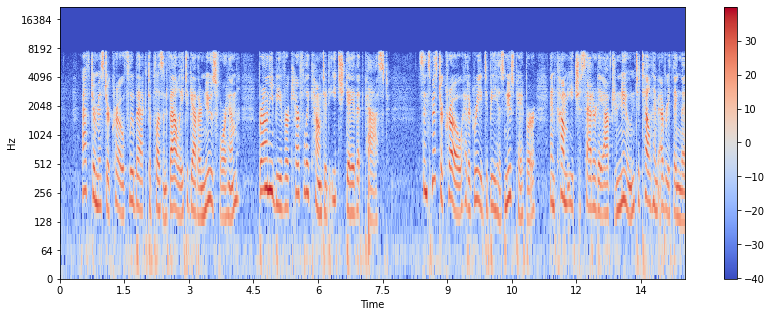

In [11]:
sample_spec = to_spectrogram(files[0])
show_spectrogram(sample_spec)

### SpecAugment Methods

In [12]:
@tf.function
def time_warp(spectrogram, W=80):
    # Returns the time-warped tensor given the spectrogram
    
    tau, f = spectrogram.shape

    # Source control point locations
    point = tf.random.uniform(shape = [], minval = W, maxval = tau - W, dtype = tf.int32)
    freq_at_point = tf.range(f//2) # The column of the spectorgram at point
    time_at_point = tf.ones_like(freq_at_point, dtype=tf.int32)*point # control points on the time axis 
    scpt = tf.cast(tf.stack((freq_at_point, time_at_point), axis = -1), dtype = tf.float32)
    scpt = tf.expand_dims(scpt, axis = 0)

    # Destination control point locations
    dt = tf.random.uniform(shape = [], minval = -W, maxval = W, dtype = tf.int32)
    dest_freq_at_point = freq_at_point
    dest_time_at_point = time_at_point + dt
    dcpt =  tf.cast(tf.stack((dest_freq_at_point, dest_time_at_point), axis = -1), dtype = tf.float32)
    dcpt = tf.expand_dims(dcpt, axis = 0)
    
    spect = tf.cast(tf.reshape(spectrogram, [1, *spectrogram.shape, 1]), dtype = tf.float32)
    warped_dat, _ = sparse_image_warp(spect, 
                                   source_control_point_locations = scpt, 
                                   dest_control_point_locations = dcpt,
                                   num_boundary_points=2) # Need to see if there is any way to have 1.5-equivalent
    warped_dat = tf.reshape(warped_dat, spectrogram.shape)
    return warped_dat


In [13]:
# sample_time_warped_spec = time_warp(sample_spec)
# show_spectrogram(sample_time_warped_spec.numpy())

In [14]:
def frequency_mask(spectrogram, F=27):
    # Adding a frequency mask
    f = tf.random.uniform([], minval = 0, maxval = F, dtype = tf.int32)
    v, T = spectrogram.shape
    f0 = tf.random.uniform([], minval = 0, maxval = v//2-f, dtype = tf.int32)
    res1 = spectrogram[:f0,:]
    res2 = spectrogram[f0+f:, :]
    mask = tf.zeros_like(spectrogram[f0:f0+f,:])
    masked_spec = tf.concat([res1, mask, res2], axis = 0)
    assert masked_spec.shape == spectrogram.shape
    return tf.cast(masked_spec, dtype = tf.float64)


In [15]:
# sample_freq_masked_spec = frequency_mask(sample_spec)
# show_spectrogram(sample_freq_masked_spec.numpy())

In [16]:
def time_mask(spectrogram, T=100):
    # Adding a time mask

    t = tf.random.uniform([], minval = 0, maxval = T, dtype = tf.int32)
    _, tau = spectrogram.shape
    t0 = tf.random.uniform([], minval = 0, maxval = tau-t, dtype = tf.int32)
    res1 = spectrogram[:,:t0]
    res2 = spectrogram[:, t0+t:]
    mask = tf.zeros_like(spectrogram[:, t0:t0+t])
    masked_spec = tf.concat([res1, mask, res2], axis = 1)
    assert masked_spec.shape == spectrogram.shape
    return tf.cast(masked_spec, dtype = tf.float64)

In [17]:
# sample_time_masked_spec = time_mask(sample_spec)
# show_spectrogram(sample_time_masked_spec.numpy())

In [18]:
# Sample with all three augmentations
# augmented_sample_spec = time_warp(frequency_mask(time_mask(sample_spec)))
# show_spectrogram(augmented_sample_spec.numpy())

In [19]:
# @tf.function
def specAugment(data,labels, W=80, F=27, T=100, mF=1, mT=1, add_random = False, verbose = False):
    """
    Apply specAugmentation to the batch of data

    params:
        data : batch of spectrograms to be augmented
        W : Time warp parameter 
        F : Frequency mask parameter
        T : Time mask parameter
        mF : no. of frequency masks to be applied
        mT : no. of time masks to be applied
        add_random : bool, determines whether random augmentations are added

    returns:
        augmented batch, with 2x (3x with add_random True) the number of samples in the input batch

    """
    aug_data = []
    Y = []
    total = len(data)
    for i, (spect, y) in enumerate(zip(data, labels)):
        if verbose:
          at.progress_bar("Getting Spectrograms ", i, total)
        aug_data.append(tf.convert_to_tensor(spect))
        Y.append(y)

        if add_random:
            augmentations = [lambda x : time_warp(x, W), 
                            lambda x :frequency_mask(x, F), 
                            lambda x:time_mask(x, T) ]
            
            num_aug = np.random.choice([1, 2, 3])
            aug = spect
            for i in range(num_aug):
                aug = augmentations[i](aug)
                aug_data.append((aug))
                Y.append(y)
        struct_aug = time_warp(spect, W)
        for i in range(mF) : struct_aug = frequency_mask(struct_aug, F)
        for i in range(mT) : struct_aug = time_mask(struct_aug, T)
 
        aug_data.append(struct_aug)
        Y.append(y)
    Y = np.array(Y)
    aug_data = tf.convert_to_tensor(aug_data, dtype = tf.float32)
    return aug_data, Y

In [20]:
# sample_augmented_specs, sample_labels = specAugment([sample_spec], [file_to_label[files[0]]], add_random = False)

In [21]:
# for spec in sample_augmented_specs:
#   show_spectrogram(spec.numpy())

In [22]:
# sample_augmented_specs[0].shape

## Data Generator

In [23]:
import string
char_list = list(string.ascii_lowercase)
char_list.extend([' ', '_', '.'])
print(char_list)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '_', '.']


In [24]:
char_to_idx = {ch:i for i, ch in enumerate(char_list)}
idx_to_char = {i:ch for i, ch in enumerate(char_list)}
print(idx_to_char)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: ' ', 27: '_', 28: '.'}


In [25]:
def label_to_sequence(label):
  return [char_to_idx[ch] for ch in label]
def sequence_to_label(sq):
  prev = "0"
  label = ""
  for idx in sq:
    ch = idx_to_char[idx]
    if ch is not prev:
      if ch == '_':
        prev = ""
        continue
      label+=ch
      if ch == '.' : break
      prev = ch
  return label

print(label_to_sequence("hello sir"))
print(sequence_to_label(label_to_sequence("ccchhaaaaaattttt_tttteeeeeer jee_e")))


[7, 4, 11, 11, 14, 26, 18, 8, 17]
chatter jee


In [26]:
labels = datset[:,1]

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padding = 'post'
truncating = 'post'

In [28]:
max_len = max([len(lab) for lab in labels])

In [29]:
class SpeechDataGenerator(tf.keras.utils.Sequence):

  def __init__(self, ids, id_to_label, batch_size = 50, dims = (1025, 1250), augment = False):
    super(SpeechDataGenerator, self).__init__()
    self.ids = ids
    self.id_to_label = id_to_label
    self.batch_size = batch_size
    self.dims = dims
    self.indices = np.arange(len(self.ids))
    self.augment = augment
    self.epoch_num = 0 # for sortagrad
  
  def __len__(self):
    return int(np.floor(len(self.ids) / self.batch_size))
  
  def on_epoch_end(self):
    np.random.shuffle(self.indices)
    self.epoch_num += 1

  def __data_generation(self, idxes):
    X = []
    y = []
    for i, idx in enumerate(idxes):
      X.append(to_spectrogram(self.ids[idx]))
      lbl = clean_label(self.id_to_label[self.ids[idx]]) + "."
      seq = label_to_sequence(lbl)
      y.append(seq)

    y = pad_sequences(y, maxlen=1025,padding = padding, truncating=truncating)
    if self.augment : X, y = specAugment(X, y,add_random=False)
    X = np.array(X)
    y = np.array(y)
    return X, y

  def __getitem__(self, index):
    den = 1 
    if self.augment : den = 2
    indices = self.indices[index*int(self.batch_size/den) : (index+1)*int(self.batch_size/den)]
    X, y = self.__data_generation(indices)
    return X, y

In [30]:
sample_gen = SpeechDataGenerator(files, file_to_label)

In [31]:
start = time.time()
sample_batch = sample_gen.__getitem__(0)
print(f"Took {time.time()-start} seconds to get 1 batch")
type(sample_batch)

Took 37.55505156517029 seconds to get 1 batch


tuple

# Model

In [32]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [33]:
from tensorflow.keras.layers import Dense, LayerNormalization, Bidirectional, Reshape, LSTM, Conv2D, Input, TimeDistributed, LayerNormalization
from tensorflow.keras.models import Model, Sequential

In [34]:
len(char_to_idx)

29

In [35]:
@tf.function
@tf.autograph.experimental.do_not_convert
def ctc_batch_loss(y_true, y_pred):
  # From SO : Todo : var init, predlength objective
  # convert y_pred from one-hot to label indices
  eos_index = char_to_idx['.']
  y_pred_ind = tf.argmax(y_pred, axis=-1)

  #to make sure y_pred has one end_of_sentence (to avoid errors)
  y_pred_end = tf.concat([y_pred_ind[:,:-1], eos_index * tf.ones_like(y_pred_ind[:,-1:])], axis = 1)

  #to make sure the first occurrence of the char is more important than subsequent ones
  occurrence_weights = tf.keras.backend.arange(start = 0, stop=1025,  dtype=tf.keras.backend.floatx())

  is_eos_true = tf.keras.backend.cast_to_floatx(tf.equal(y_true, eos_index))
  is_eos_pred = tf.keras.backend.cast_to_floatx(tf.equal(y_pred_end, eos_index))
  #lengths
  true_lengths = 1 + tf.argmax(occurrence_weights * is_eos_true, axis=1)
  pred_lengths = 1 + tf.argmax(occurrence_weights * is_eos_pred, axis=1)

  #reshape
  true_lengths = tf.reshape(true_lengths, (-1,1))
  pred_lengths = tf.reshape(pred_lengths, (-1,1))

  loss_ = tf.keras.backend.ctc_batch_cost(y_true, y_pred, pred_lengths, true_lengths)
  return tf.reduce_mean(loss_)

In [36]:
# The model Class
class DSModel():

  def __init__(self, num_conv=1, conv_filters = 4, conv_kernel = (5, 5), num_rnn=1, rnn_units = 500,spect_shape = (1025, 1250)):
    self.num_conv = num_conv
    self.conv_filters = conv_filters
    self.conv_kernel = conv_kernel
    self.num_rnn = num_rnn
    self.rnn_units = rnn_units
    self.spect_shape = spect_shape

    # Layers
    self.input = Input(shape = (self.spect_shape), name = "Input")
    self.spect2im = Reshape((*self.spect_shape, 1))
    self.convs = [Conv2D(conv_filters, conv_kernel, padding = 'same', name = f"Conv{i}") for i in range(num_conv)]
    self.conv2rnn = Reshape((spect_shape[0], spect_shape[1]*conv_filters))
    self.rnns = [Bidirectional(LSTM(self.rnn_units, return_sequences=True), name = f"RNN{i}") for i in range(num_rnn)]
    self.layernorms = [LayerNormalization(name = f"LayerNorm{i}") for i in range(num_rnn)]
    self.output = TimeDistributed(Dense(29, activation = 'softmax'), name="Logits_Output")

    # Model
    self.model = None

  def build(self, show_summary = True):

    X = self.input
    X_ = self.spect2im(X)
    for i in range(self.num_conv):
      X_ = self.convs[i](X_)
    X_ = self.conv2rnn(X_)
    for i in range(self.num_rnn):
      X_ = self.rnns[i](X_)
      X_ = self.layernorms[i](X_)
    
    logits = self.output(X_)

    self.model = tf.keras.models.Model(inputs = X, outputs = logits)
    self.model.compile(optimizer = 'adam', loss = ctc_batch_loss, metrics = ['accuracy'])
    if show_summary:
      self.model.summary()

    return self.model

  def restore(self,checkpoint_path):
    if self.model is None:
      print("Building the model first.")
      self.build()
    self.model.load_weights(checkpoint_path)



# Training

In [37]:
speech_gen = SpeechDataGenerator(files, file_to_label)

In [38]:
ds_model = DSModel(num_conv = 2, num_rnn = 3)
model = ds_model.build()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 1025, 1250)]      0         
_________________________________________________________________
reshape (Reshape)            (None, 1025, 1250, 1)     0         
_________________________________________________________________
Conv0 (Conv2D)               (None, 1025, 1250, 4)     104       
_________________________________________________________________
Conv1 (Conv2D)               (None, 1025, 1250, 4)     404       
_________________________________________________________________
reshape_1 (Reshape)          (None, 1025, 5000)        0         
_________________________________________________________________
RNN0 (Bidirectional)         (None, 1025, 1000)        22004000  
_________________________________________________________________
LayerNorm0 (LayerNormalizati (None, 1025, 1000)        2000  

In [39]:
# Checkpoint Callback
import os
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/DeepSpeechTraining/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1, period = 5)
# model.fit(... , callbacks=[cp_callback])

In [40]:
ds_model.restore(checkpoint_path)

In [ ]:
hist = model.fit(speech_gen, epochs = 20, callbacks=[cp_callback])

Epoch 1/20
30/30 [==============================] - 1338s 45s/step - loss: 527.8391 - accuracy: 0.0079
Epoch 2/20
30/30 [==============================] - 1345s 45s/step - loss: 534.4601 - accuracy: 0.0012
Epoch 3/20
30/30 [==============================] - 1361s 45s/step - loss: 524.5557 - accuracy: 0.0011
Epoch 4/20
30/30 [==============================] - 1372s 46s/step - loss: 524.1109 - accuracy: 0.0013
Epoch 5/20
25/30 [========================>.....] - ETA: 3:49 - loss: 525.5864 - accuracy: 0.0014

In [42]:
2+3

5

In [ ]:
def plothist(history):
  loss_hist = np.array(history.history['loss'])/max(history.history['loss'])
  acc_hist = np.array(history.history['accuracy'])/max(history.history['accuracy'])
  plt.plot(acc_hist, label = 'accuracy')
  plt.plot(loss_hist, label="loss/max_loss")
  plt.xlabel("Epochs")
  plt.ylabel("Metric")
  plt.legend()
  plt.show()

plothist(hist)


In [44]:
def sequence_to_label_(sq):
  prev = "0"
  label = ""
  for idx in sq:
    ch = idx_to_char[idx]
    if ch is not prev:
      if ch == '_':
        prev = ""
        continue
      label+=ch
      # if ch == '.' : break
    prev = ch
  return label

In [45]:
def get_prediction(model, audio_file):
  spect = to_spectrogram(audio_file)
  pred = model.predict(tf.convert_to_tensor([spect]))
  ids = tf.argmax(pred, axis = -1)
  label = sequence_to_label_(ids.numpy()[0])
  return label

get_prediction(model, files[2])


'that .as robr.l .e .e'

In [46]:
 IPython.display.Audio(files[2])